# Étape 3 : Fine-tuning du modèle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device utilisé: {device}")

# Mapping des labels pour Allociné
label_mapping = {0: 'Négatif', 1: 'Positif'}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

 Device utilisé: cuda


In [2]:
# ============================================================================
# CHARGEMENT DES DONNÉES ALLOCINÉ
# ============================================================================

print("\n" + "="*60)
print(" CHARGEMENT DES DONNÉES ALLOCINÉ")
print("="*60)

# Charger les données
train_df = pd.read_csv('train_data_allocine.csv')
test_df = pd.read_csv('test_data_allocine.csv')

print(f" Données chargées :")
print(f"   Train: {len(train_df)} avis de films")
print(f"   Test: {len(test_df)} avis de films")

# Vérifier la distribution
print(f"\n Distribution des classes dans l'entraînement :")
train_counts = train_df['label'].value_counts().sort_index()
for label, count in train_counts.items():
    percentage = count / len(train_df) * 100
    print(f"   {label_mapping[label]}: {count} avis ({percentage:.1f}%)")

# Statistiques sur la longueur des textes
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

print(f"\n Statistiques des textes :")
print(f"   Longueur moyenne train: {train_df['text_length'].mean():.0f} caractères")
print(f"   Longueur médiane train: {train_df['text_length'].median():.0f} caractères")
print(f"   Longueur max train: {train_df['text_length'].max()} caractères")


 CHARGEMENT DES DONNÉES ALLOCINÉ
 Données chargées :
   Train: 2000 avis de films
   Test: 400 avis de films

 Distribution des classes dans l'entraînement :
   Négatif: 1000 avis (50.0%)
   Positif: 1000 avis (50.0%)

 Statistiques des textes :
   Longueur moyenne train: 544 caractères
   Longueur médiane train: 398 caractères
   Longueur max train: 2000 caractères


In [3]:
# ============================================================================
# PRÉPARATION DU MODÈLE ET TOKENIZER
# ============================================================================

print("\n" + "="*60)
print(" PRÉPARATION DU MODÈLE POUR LE FINE-TUNING")
print("="*60)

model_name = "distilbert-base-multilingual-cased"
print(f" Chargement de {model_name} pour fine-tuning...")

# Charger le tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Charger le modèle FRAIS
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

print(f" Modèle et tokenizer chargés")
print(f" Nombre de paramètres: {model.num_parameters():,}")

# Analyser la longueur des tokens pour optimiser max_length
print(f"\n Analyse de la tokenisation...")
sample_texts = train_df['text'].sample(n=100).tolist()
token_lengths = []

for text in sample_texts:
    tokens = tokenizer(text, truncation=False)['input_ids']
    token_lengths.append(len(tokens))

max_length = int(np.percentile(token_lengths, 95))  # 95% des textes
max_length = min(max_length, 512)  # Limiter à 512 pour la mémoire

print(f" Longueur optimale de tokenisation: {max_length} tokens")
print(f"   (couvre 95% des textes sans troncature excessive)")


 PRÉPARATION DU MODÈLE POUR LE FINE-TUNING
 Chargement de distilbert-base-multilingual-cased pour fine-tuning...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


 Modèle et tokenizer chargés
 Nombre de paramètres: 135,326,210

 Analyse de la tokenisation...
 Longueur optimale de tokenisation: 431 tokens
   (couvre 95% des textes sans troncature excessive)


In [4]:
# ============================================================================
# PRÉPARATION DES DATASETS
# ============================================================================

print("\n" + "="*60)
print(" PRÉPARATION DES DATASETS POUR L'ENTRAÎNEMENT")
print("="*60)

def tokenize_function(examples):
    """Tokenise les textes pour l'entraînement"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=False,  # Padding dynamique
        max_length=max_length
    )

# Créer les datasets Hugging Face
print(" Conversion en format Dataset...")
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokeniser les datasets
print(" Tokenisation...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Configurer les colonnes pour l'entraînement
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

# Définir le format pour PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print(f" Datasets préparés :")
print(f"   Train: {len(train_dataset)} exemples")
print(f"   Test: {len(test_dataset)} exemples")

# Aperçu d'un exemple tokenisé
print(f"\n Exemple tokenisé :")
example = train_dataset[0]
original_text = train_df.iloc[0]['text']
print(f"   Text original: \"{original_text[:100]}...\"")
print(f"   Input IDs shape: {example['input_ids'].shape}")
print(f"   Label: {example['labels']} ({label_mapping[example['labels'].item()]})")


 PRÉPARATION DES DATASETS POUR L'ENTRAÎNEMENT
 Conversion en format Dataset...
 Tokenisation...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

 Datasets préparés :
   Train: 2000 exemples
   Test: 400 exemples

 Exemple tokenisé :
   Text original: "J'ai vu ce film en avant première et je peux vous assurer qu'en aucun cas vous ne perdrez votre temp..."
   Input IDs shape: torch.Size([110])
   Label: 1 (Positif)


In [5]:
# ============================================================================
# CONFIGURATION DE L'ENTRAÎNEMENT OPTIMISÉE
# ============================================================================

print("\n" + "="*60)
print(" CONFIGURATION DE L'ENTRAÎNEMENT")
print("="*60)

# Créer le répertoire de sortie
output_dir = "./fine_tuned_model_allocine"
os.makedirs(output_dir, exist_ok=True)

# Configuration optimisée pour le dataset Allociné
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=3,
    seed=42,
    dataloader_pin_memory=False,
    fp16=True,
    gradient_accumulation_steps=2,
    report_to=[]
)

print(f" Configuration d'entraînement optimisée :")
print(f"   Époques: {training_args.num_train_epochs}")
print(f"   Batch size effectif: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Warmup steps: {training_args.warmup_steps}")
print(f"   Weight decay: {training_args.weight_decay}")
print(f"   FP16 activé: {training_args.fp16}")


 CONFIGURATION DE L'ENTRAÎNEMENT
 Configuration d'entraînement optimisée :
   Époques: 3
   Batch size effectif: 32
   Learning rate: 2e-05
   Warmup steps: 200
   Weight decay: 0.01
   FP16 activé: True


In [6]:
# ============================================================================
# MÉTRIQUES D'ÉVALUATION
# ============================================================================

def compute_metrics(eval_pred):
    """Calcule les métriques d'évaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculer les métriques
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    # Métriques par classe
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None, labels=[0, 1]
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'f1_negative': f1_per_class[0],
        'f1_positive': f1_per_class[1],
        'precision_negative': precision_per_class[0],
        'precision_positive': precision_per_class[1]
    }

In [7]:
# ============================================================================
# CRÉATION DU TRAINER
# ============================================================================

print("\n" + "="*60)
print(" CRÉATION DU TRAINER")
print("="*60)

# Data collator pour le padding dynamique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Créer le trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print(" Trainer créé avec succès !")
print(f" Dataset d'entraînement: {len(train_dataset)} exemples")
print(f" Dataset d'évaluation: {len(test_dataset)} exemples")


 CRÉATION DU TRAINER
 Trainer créé avec succès !
 Dataset d'entraînement: 2000 exemples
 Dataset d'évaluation: 400 exemples


In [8]:
# ============================================================================
# LANCEMENT DE L'ENTRAÎNEMENT
# ============================================================================

print("\n" + "="*60)
print(" LANCEMENT DU FINE-TUNING SUR ALLOCINÉ")
print("="*60)

print(" Début de l'entraînement...")
print(" Entraînement sur des données réelles d'avis de films...")
print(" Objectif: Améliorer significativement vs baseline")

# Lancer l'entraînement
train_result = trainer.train()

print("\n Entraînement terminé !")
print(f" Résultats finaux :")
print(f"   Loss finale: {train_result.training_loss:.4f}")
print(f"   Temps d'entraînement: {train_result.metrics['train_runtime']:.1f}s")



 LANCEMENT DU FINE-TUNING SUR ALLOCINÉ
 Début de l'entraînement...
 Entraînement sur des données réelles d'avis de films...
 Objectif: Améliorer significativement vs baseline


Step,Training Loss,Validation Loss



 Entraînement terminé !
 Résultats finaux :
   Loss finale: 0.5522
   Temps d'entraînement: 67.6s


In [9]:
# ============================================================================
# ÉVALUATION DU MODÈLE FINE-TUNÉ
# ============================================================================

print("\n" + "="*60)
print(" ÉVALUATION DU MODÈLE FINE-TUNÉ")
print("="*60)

# Évaluer sur le test set
eval_results = trainer.evaluate()

print(f" Métriques finales sur le test set :")
print(f"   Accuracy: {eval_results['eval_accuracy']:.3f} ({eval_results['eval_accuracy']*100:.1f}%)")
print(f"   F1-Score global: {eval_results['eval_f1']:.3f}")
print(f"   Precision: {eval_results['eval_precision']:.3f}")
print(f"   Recall: {eval_results['eval_recall']:.3f}")
print(f"   Loss: {eval_results['eval_loss']:.4f}")

print(f"\n Métriques par classe :")
print(f"   F1-Score Négatif: {eval_results['eval_f1_negative']:.3f}")
print(f"   F1-Score Positif: {eval_results['eval_f1_positive']:.3f}")
print(f"   Precision Négatif: {eval_results['eval_precision_negative']:.3f}")
print(f"   Precision Positif: {eval_results['eval_precision_positive']:.3f}")


 ÉVALUATION DU MODÈLE FINE-TUNÉ


 Métriques finales sur le test set :
   Accuracy: 0.838 (83.8%)
   F1-Score global: 0.836
   Precision: 0.848
   Recall: 0.838
   Loss: 0.3582

 Métriques par classe :
   F1-Score Négatif: 0.851
   F1-Score Positif: 0.822
   Precision Négatif: 0.787
   Precision Positif: 0.909


In [10]:
# ============================================================================
# COMPARAISON AVEC LE MODÈLE DE BASE
# ============================================================================

print("\n" + "="*60)
print(" COMPARAISON AVANT/APRÈS FINE-TUNING")
print("="*60)

# Charger les métriques de base
try:
    with open('baseline_metrics_allocine.json', 'r') as f:
        baseline_metrics = json.load(f)

    print(f" AMÉLIORATION OBTENUE :")
    print(f"   Accuracy: {baseline_metrics['accuracy']:.3f} → {eval_results['eval_accuracy']:.3f}")
    print(f"   F1-Score: {baseline_metrics['f1']:.3f} → {eval_results['eval_f1']:.3f}")
    print(f"   Precision: {baseline_metrics['precision']:.3f} → {eval_results['eval_precision']:.3f}")
    print(f"   Recall: {baseline_metrics['recall']:.3f} → {eval_results['eval_recall']:.3f}")

    # Calculer les améliorations
    acc_improvement = (eval_results['eval_accuracy'] - baseline_metrics['accuracy']) * 100
    f1_improvement = (eval_results['eval_f1'] - baseline_metrics['f1']) * 100

    print(f"\n GAINS ABSOLUS :")
    print(f"   Accuracy: {acc_improvement:+.1f} points de pourcentage")
    print(f"   F1-Score: {f1_improvement:+.1f} points")



except FileNotFoundError:
    print(" Métriques de base non trouvées")
    baseline_metrics = None


 COMPARAISON AVANT/APRÈS FINE-TUNING
 AMÉLIORATION OBTENUE :
   Accuracy: 0.505 → 0.838
   F1-Score: 0.349 → 0.836
   Precision: 0.626 → 0.848
   Recall: 0.505 → 0.838

 GAINS ABSOLUS :
   Accuracy: +33.2 points de pourcentage
   F1-Score: +48.8 points



 Création du graphique de comparaison...


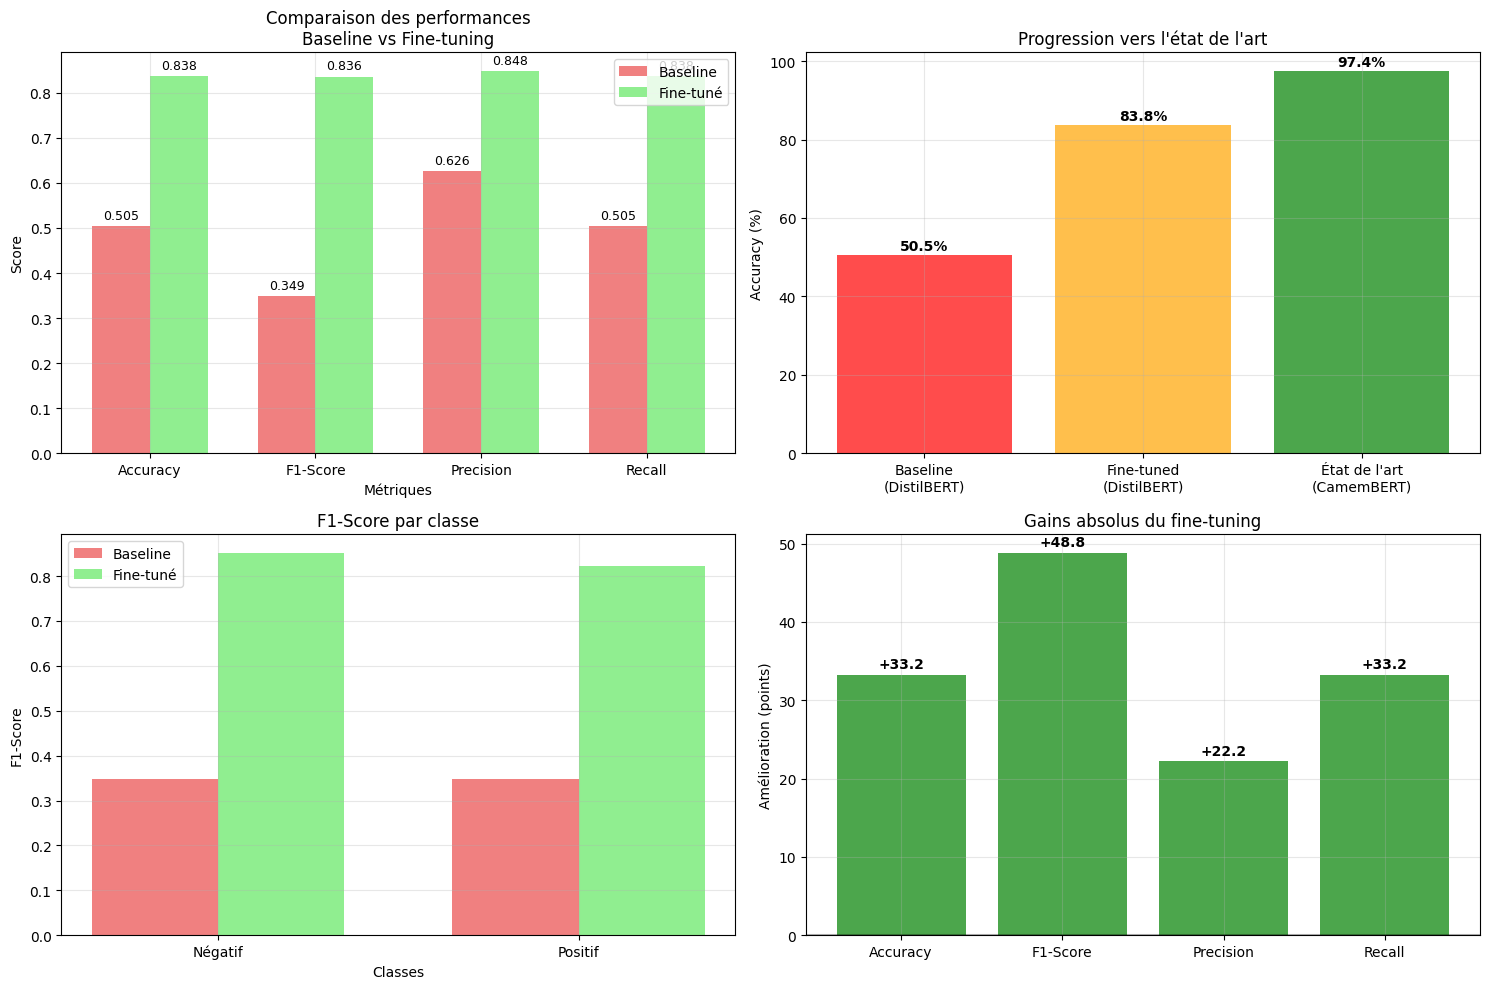

In [11]:
# ============================================================================
# VISUALISATION DES AMÉLIORATIONS
# ============================================================================

if baseline_metrics:
    print("\n Création du graphique de comparaison...")

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Comparaison des métriques principales
    ax1 = axes[0, 0]
    metrics_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    baseline_values = [
        baseline_metrics['accuracy'],
        baseline_metrics['f1'],
        baseline_metrics['precision'],
        baseline_metrics['recall']
    ]
    finetuned_values = [
        eval_results['eval_accuracy'],
        eval_results['eval_f1'],
        eval_results['eval_precision'],
        eval_results['eval_recall']
    ]

    x = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, baseline_values, width, label='Baseline', color='lightcoral')
    bars2 = ax1.bar(x + width/2, finetuned_values, width, label='Fine-tuné', color='lightgreen')

    ax1.set_xlabel('Métriques')
    ax1.set_ylabel('Score')
    ax1.set_title('Comparaison des performances\nBaseline vs Fine-tuning')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_names)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Ajouter les valeurs sur les barres
    def autolabel(ax, rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    autolabel(ax1, bars1)
    autolabel(ax1, bars2)

    # 2. Évolution de l'accuracy
    ax2 = axes[0, 1]
    models = ['Baseline\n(DistilBERT)', 'Fine-tuned\n(DistilBERT)', 'État de l\'art\n(CamemBERT)']
    accuracies = [baseline_metrics['accuracy']*100, eval_results['eval_accuracy']*100, 97.44]
    colors = ['red', 'orange', 'green']

    bars = ax2.bar(models, accuracies, color=colors, alpha=0.7)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Progression vers l\'état de l\'art')
    ax2.grid(True, alpha=0.3)

    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 3. F1-Score par classe
    ax3 = axes[1, 0]
    classes = ['Négatif', 'Positif']
    f1_baseline = [baseline_metrics['f1'], baseline_metrics['f1']]
    f1_finetuned = [eval_results['eval_f1_negative'], eval_results['eval_f1_positive']]

    x_classes = np.arange(len(classes))
    bars1 = ax3.bar(x_classes - width/2, f1_baseline, width, label='Baseline', color='lightcoral')
    bars2 = ax3.bar(x_classes + width/2, f1_finetuned, width, label='Fine-tuné', color='lightgreen')

    ax3.set_xlabel('Classes')
    ax3.set_ylabel('F1-Score')
    ax3.set_title('F1-Score par classe')
    ax3.set_xticks(x_classes)
    ax3.set_xticklabels(classes)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Amélioration absolue
    ax4 = axes[1, 1]
    improvements = [
        acc_improvement,
        f1_improvement,
        (eval_results['eval_precision'] - baseline_metrics['precision']) * 100,
        (eval_results['eval_recall'] - baseline_metrics['recall']) * 100
    ]

    colors_improvement = ['green' if x > 0 else 'red' for x in improvements]
    bars = ax4.bar(metrics_names, improvements, color=colors_improvement, alpha=0.7)
    ax4.set_ylabel('Amélioration (points)')
    ax4.set_title('Gains absolus du fine-tuning')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.grid(True, alpha=0.3)

    for bar, improvement in zip(bars, improvements):
        ax4.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (0.5 if improvement > 0 else -1),
                f'{improvement:+.1f}', ha='center',
                va='bottom' if improvement > 0 else 'top', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [12]:
# ============================================================================
# SAUVEGARDE DU MODÈLE FINE-TUNÉ
# ============================================================================

print("\n" + "="*60)
print(" SAUVEGARDE DU MODÈLE FINE-TUNÉ")
print("="*60)

# Sauvegarder le modèle et le tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f" Modèle sauvegardé dans : {output_dir}")

# Sauvegarder les métriques du modèle fine-tuné
finetuned_metrics = {
    'model_name': model_name,
    'dataset': 'allocine',
    'train_size': len(train_df),
    'test_size': len(test_df),
    'accuracy': eval_results['eval_accuracy'],
    'f1': eval_results['eval_f1'],
    'precision': eval_results['eval_precision'],
    'recall': eval_results['eval_recall'],
    'f1_negative': eval_results['eval_f1_negative'],
    'f1_positive': eval_results['eval_f1_positive'],
    'loss': eval_results['eval_loss'],
    'training_loss': train_result.training_loss,
    'training_time': train_result.metrics['train_runtime'],
    'num_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate,
    'batch_size': training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps
}

with open('finetuned_metrics_allocine.json', 'w') as f:
    json.dump(finetuned_metrics, f, indent=2)

print(f" Métriques sauvegardées dans : finetuned_metrics_allocine.json")


 SAUVEGARDE DU MODÈLE FINE-TUNÉ
 Modèle sauvegardé dans : ./fine_tuned_model_allocine
 Métriques sauvegardées dans : finetuned_metrics_allocine.json


In [13]:
# ============================================================================
# TEST RAPIDE DU MODÈLE FINE-TUNÉ
# ============================================================================

print("\n" + "="*60)
print(" TEST RAPIDE DU MODÈLE FINE-TUNÉ")
print("="*60)

# Tester quelques exemples d'avis de films
test_examples = [
    "Ce film est un véritable chef-d'œuvre ! L'histoire est captivante, les acteurs sont formidables et la réalisation est impeccable.",
    "Film complètement raté. Scénario prévisible, dialogues creux et mise en scène bâclée. Une perte de temps totale.",
    "Un bon divertissement sans prétention. Ça se regarde facilement mais sans plus, rien d'exceptionnel.",
    "Magnifique ! Des images à couper le souffle, une bande sonore extraordinaire. Du grand cinéma !",
    "Très déçu. Après toute cette attente, le film ne tient pas ses promesses. Ennuyeux et mal ficelé."
]

print(" Prédictions du modèle fine-tuné sur de nouveaux avis :")

for i, text in enumerate(test_examples, 1):
    # Tokeniser
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prédire
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    print(f"\n{i}. \"{text}\"")
    print(f"   → Prédiction: {label_mapping[predicted_class]}")
    print(f"   → Confiance: {confidence:.3f}")


 TEST RAPIDE DU MODÈLE FINE-TUNÉ
 Prédictions du modèle fine-tuné sur de nouveaux avis :

1. "Ce film est un véritable chef-d'œuvre ! L'histoire est captivante, les acteurs sont formidables et la réalisation est impeccable."
   → Prédiction: Positif
   → Confiance: 0.964

2. "Film complètement raté. Scénario prévisible, dialogues creux et mise en scène bâclée. Une perte de temps totale."
   → Prédiction: Négatif
   → Confiance: 0.940

3. "Un bon divertissement sans prétention. Ça se regarde facilement mais sans plus, rien d'exceptionnel."
   → Prédiction: Négatif
   → Confiance: 0.643

4. "Magnifique ! Des images à couper le souffle, une bande sonore extraordinaire. Du grand cinéma !"
   → Prédiction: Positif
   → Confiance: 0.965

5. "Très déçu. Après toute cette attente, le film ne tient pas ses promesses. Ennuyeux et mal ficelé."
   → Prédiction: Négatif
   → Confiance: 0.943


In [14]:
# ============================================================================
# RÉCAPITULATIF FINAL
# ============================================================================

print("\n" + "="*60)
print(" FINE-TUNING TERMINÉ AVEC SUCCÈS !")
print("="*60)

print(f" Récapitulatif du projet :")
print(f"   • Dataset: Allociné (avis de films français)")
print(f"   • Modèle: {model_name}")
print(f"   • Entraînement: {len(train_df)} exemples")
print(f"   • Test: {len(test_df)} exemples")
print(f"   • Performance finale: {eval_results['eval_accuracy']*100:.1f}% accuracy")

if baseline_metrics:
    print(f"   • Amélioration vs baseline: +{acc_improvement:.1f} points")

print(f"\n Fichiers générés :")
print(f"   • {output_dir}/ : Modèle fine-tuné complet")
print(f"   • finetuned_metrics_allocine.json : Métriques détaillées")
print(f"   • logs/ : Logs d'entraînement TensorBoard")



 FINE-TUNING TERMINÉ AVEC SUCCÈS !
 Récapitulatif du projet :
   • Dataset: Allociné (avis de films français)
   • Modèle: distilbert-base-multilingual-cased
   • Entraînement: 2000 exemples
   • Test: 400 exemples
   • Performance finale: 83.8% accuracy
   • Amélioration vs baseline: +33.2 points

 Fichiers générés :
   • ./fine_tuned_model_allocine/ : Modèle fine-tuné complet
   • finetuned_metrics_allocine.json : Métriques détaillées
   • logs/ : Logs d'entraînement TensorBoard
